In [1]:
from keras.models import Sequential, clone_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, concatenate, Input
from scipy.stats import zscore
from matplotlib import pyplot
import pandas as pd
import numpy as np
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

Using TensorFlow backend.


In [2]:
def Define_Model():
    
    model_input = Input(shape=(19,1,50))
    x = Conv2D(20, (1, 3), activation='relu', kernel_initializer='glorot_uniform', data_format='channels_first')(model_input)
    x = MaxPooling2D((1, 2), data_format='channels_first')(x)
    x = Conv2D(40, (1, 3), activation='tanh', kernel_initializer='glorot_uniform', data_format='channels_first')(x)
    x = MaxPooling2D((1, 2), data_format='channels_first')(x)
    x = Conv2D(60, (1, 3), activation='relu', kernel_initializer='glorot_uniform', data_format='channels_first')(x)
    
    max_pool_output = MaxPooling2D((1, 3), data_format='channels_first')(x)
    conv_output = Conv2D(80, (1, 3), activation='tanh', kernel_initializer='glorot_uniform', data_format='channels_first')(max_pool_output)
    
    max_pool_output_flattened = Flatten(data_format='channels_first')(max_pool_output)
    conv_output_flattened = Flatten(data_format='channels_first')(conv_output)
    
    combined_layer = concatenate([max_pool_output_flattened, conv_output_flattened])
    
    deep_mf = Dense(100, activation='relu')(combined_layer)
    out = Dense(4, activation='softmax')(deep_mf)
    
    model = Model(inputs=model_input, outputs=out)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    #print(model.summary())
    return model  

In [3]:
def read_and_reshape_data(filename):
    df = pd.read_csv(filename)
    df = df.drop(df.columns[[0]], axis=1)
    df_num = df.select_dtypes(include=[np.float64])
    df_normalized = df_num.apply(zscore)
    df[df_normalized.columns] = df_normalized
    np_df = df.to_numpy()
    reshaped_df = np.reshape(np_df, (50, 140, 23))
    return reshaped_df

In [4]:
def get_training_and_testing_data(a, axis):
    b = np.swapaxes(a, 0, 1)
    np.random.shuffle(b)
    shuffled_data = np.swapaxes(b, 0, 1)
    training_data = np.take(shuffled_data, np.arange(200), axis=1)
    testing_data = np.take(shuffled_data, np.arange(200,560), axis=1)
    return training_data, testing_data    

In [5]:
def get_input_and_labels(data,size):
    input_df = data[:,:,0:19]
    input_df = np.expand_dims(input_df, axis=3)
    input_df = np.moveaxis(input_df, 0, 3)

    labels = data[:,:,19:23]
    labels_squeezed = labels[1,:,:].reshape(size,4)
    
    return input_df, labels_squeezed

In [6]:
def result_show(history):
    pyplot.figure(figsize=(15,5))
    pyplot.tight_layout()
    
    #plot the loss graph
    pyplot.subplot(1,2,1)
    pyplot.title('cross entropy loss', size=20)
    pyplot.xlabel('epoch', size=14)
    pyplot.ylabel('loss', size=14)
    pyplot.plot(history.history['loss'],color ='blue',label = 'training')
    pyplot.plot(history.history['val_loss'],color ='orange',label ='testing')
    pyplot.legend()
    
    #plot accuracy graph
    pyplot.subplot(1,2,2)
    pyplot.title('accuracy', size=20)
    pyplot.xlabel('epoch', size=14)
    pyplot.ylabel('accuracy', size=14)
    pyplot.plot(history.history['accuracy'],color ='blue',label = 'training')
    pyplot.plot(history.history['val_accuracy'],color ='orange',label ='testing')
    pyplot.legend()
    

In [7]:
def run_test(training_data, testing_data):
    model = Define_Model();
    training_input, training_output = get_input_and_labels(training_data, 200)
    testing_input, testing_output = get_input_and_labels(testing_data, 360)
    
    mod = model.fit(training_input, training_output,  batch_size=5, epochs=15, validation_split=0.5)
    loss, metrics = model.evaluate(testing_input, testing_output, batch_size=5)
    
    print('------> %.3f' % (metrics * 100.0))
    result_show(mod)
    

In [8]:
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

In [9]:
reshaped_rf = read_and_reshape_data('../datasets/rf.csv')
reshaped_rb = read_and_reshape_data('../datasets/rb.csv')
reshaped_lf = read_and_reshape_data('../datasets/lf.csv')
reshaped_lb = read_and_reshape_data('../datasets/lb.csv')

In [10]:
combined_data = np.concatenate([reshaped_rf, reshaped_rb, reshaped_lf, reshaped_lb], axis=1)

In [11]:
training_data, testing_data = get_training_and_testing_data(combined_data, 1)

Train on 100 samples, validate on 100 samples
Epoch 1/15
100/100 [==============================] - 1s 6ms/step - loss: 1.1385 - accuracy: 0.6400 - val_loss: 0.9331 - val_accuracy: 0.7000
Epoch 2/15
100/100 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.8800 - val_loss: 0.5380 - val_accuracy: 1.0000
Epoch 3/15
100/100 [==============================] - 0s 2ms/step - loss: 0.3735 - accuracy: 0.9900 - val_loss: 0.3109 - val_accuracy: 1.0000
Epoch 4/15
100/100 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 1.0000 - val_loss: 0.1796 - val_accuracy: 1.0000
Epoch 5/15
100/100 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 1.0000 - val_loss: 0.1184 - val_accuracy: 1.0000
Epoch 6/15
100/100 [==============================] - 0s 2ms/step - loss: 0.0839 - accuracy: 1.0000 - val_loss: 0.0877 - val_accuracy: 1.0000
Epoch 7/15
100/100 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 1.0000 - 

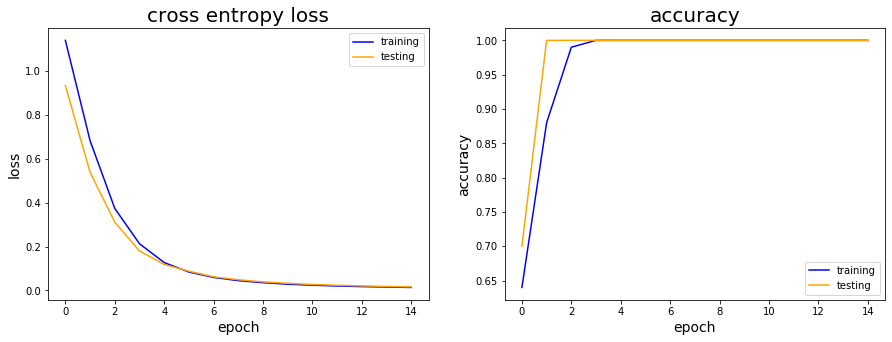

In [12]:
run_test(training_data, testing_data)